In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.externals import joblib

In [2]:
#REFERENCE-https://www.kaggle.com/priyanka4pc/m5-model
#code to reduce memory consumption
import numpy as np
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
#DOWNLOADING DATASET
!curl --header "Host: storage.googleapis.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-GB,en;q=0.9" --header "Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626948840&Signature=SSQ5BiEZ6Pmadghnnd5oqppi0b6P%2F5utcPz4P56WcO39%2FSNjcZ6NGvVTD3SrZ6XkO%2F1yqFy0kGzmTL%2BEZcM3h%2FcoeLeVKWFHYabFLU2oS5121z85ts4lARqSLSZ10PZMxZEFKwH3TP0%2BJ6nKwMk2M5lsLrGGV1X3IZwU%2F6zzcDFqLrjkxVxdrGiz%2FRN49MVAf3fZNV3wYqaKBjilZFrOoNkCj9Akwf0Vew6lRSwu%2BTWSWbnsaWuW7FJqnb%2FTRTiPvDt%2FcIDtKhPOXNdBO6XneU%2BKBbrmTD3Yu%2F0ALxD4ve9nT3XefbvpkkoQSEoO5w2ehjWs%2B6Zw55LaikYycXsVJg%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -L -o "m5-forecasting-accuracy.zip"
!unzip '/content/m5-forecasting-accuracy.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.7M  100 45.7M    0     0  25.9M      0  0:00:01  0:00:01 --:--:-- 25.9M
Archive:  /content/m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


In [ ]:
#importing dataset
calendar=pd.read_csv('calendar.csv')
sales=pd.read_csv('sales_train_evaluation.csv')
price=pd.read_csv('sell_prices.csv')

In [ ]:
#useful for deploying model
sales_desc=sales[['item_id','store_id']]
sales_desc

,item_id,store_id
0,HOBBIES_1_001,CA_1
1,HOBBIES_1_002,CA_1
2,HOBBIES_1_003,CA_1
3,HOBBIES_1_004,CA_1
4,HOBBIES_1_005,CA_1
...,...,...
30485,FOODS_3_823,WI_3
30486,FOODS_3_824,WI_3
30487,FOODS_3_825,WI_3
30488,FOODS_3_826,WI_3


In [ ]:
#MELTING DATAFRAME
sales_melt=sales.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d',value_name='sale')

#MERGING SALES DF AND CALENDAR DF
sales_pivot=sales_melt.merge(calendar,on='d',how='left')

#MERGING SALES DF AND PRICE DF
final_df=sales_pivot.merge(price,on=['store_id', 'item_id', 'wm_yr_wk'],how='left')

Mem. usage decreased to 678.95 Mb (33.3% reduction)


In [ ]:
#CONVERTING OBJECT TYPE TO CATEGORY
object_columns=final_df.select_dtypes('object').columns
final_df[object_columns]=final_df[object_columns].astype('category')


In [ ]:
#REDUCING MEMORY USAGE BY DOWNCASTING
final_df=reduce_mem_usage(final_df)

In [ ]:
final_df.info()

In [ ]:
def data_modelling(X):
  '''the function takes single argument and performs all the preprocessing and feature
  engineering on top of that and also performs modelling of data..
  the function will return the predicted output of our task'''

  #HERE THE FUNCTION ARGUMENT WILL TAKE A DATAFRAME AS AN INPUT

  #PERFORMING ALL THE REQUIRED DATA PREPROCESSING
  #ENCODING ALL CATEGORICAL FEATURES
  '''for i in X.columns:
    try:
        X[i] = X[i].cat.codes
    except AttributeError:
        pass

  #HERE WE ARE STRIPPING THE D FROM D COLUMN AND MAKING IT INTEGER...IT WILL HELP US TO SPLIT THE DATASET USING DAY
  X['day'] = X['d'].map(lambda x: x.split('_')[1]).astype('int')

  #BEFORE SPLITTING THE DATASET WE ARE REMOVING THE WEEKDAY COLUMN AS WE ALREADY HAVE WDAY COLUMN WHICH IS NUMERIC REPRESENTATION OF WEEKDAY..
  #WE ARE ALSO DROPING 'D' COLUMN SINCE WE HAVE CONVERTED IT TO A COLUMN 'DAY'
  X=X.drop(['weekday','d'],axis=1)

  #DEALING WITH NAN VALUES
  X['sell_price'] = X['sell_price'].fillna(X.groupby('id')['sell_price'].transform('median'))

  

  #PERFORMING FEARURE ENGINEERINGS

  #FEATURE ENGINNERING USING DATE(TYPE=datetime) COLUMN
  X.drop(['wm_yr_wk'],axis=1,inplace=True)
  X['week_of_year']=X['date'].dt.week

  #WHETEHER THE DAY FALLS IN WEEKEND OR NOT
  X['is_weekend']=X['wday'].map(lambda x:1 if x<=2 else 0)

  #WHETHER THE DAY IS THE STARING OF MONTH OR ENDING OR MONTH
  month_start=X['date'].dt.is_month_start.map(lambda x:1 if x==True else 0)
  month_end=X['date'].dt.is_month_end.map(lambda x:2 if x==True else 0)
  X['is_month_start_or_end']=month_start+month_end

  #WHETHER THE DAY IS LESS THAN HALF THE MONTH OR MORE
  X['is_first15_day_or_last15_day']=X['date'].dt.day.map(lambda x:1 if x<=15 else 0)

  #WHETHER ITS CHRISTMAS OR NOT ON SPECIFIC DAY
  X['is_christmas']=X['event_name_1'].map(lambda x:1 if x==1 else 0)
  X.drop(['date'],axis=1,inplace=True)


  X=reduce_mem_usage(X)

  #LAG FEATURES
  from tqdm import tqdm
  lags=[1,7,14,21,28,30,31]
  for lag in tqdm(lags):
    X["lag_" + str(lag)] = X.groupby("id")["sale"].shift(lag)
    X["lag_" + str(lag)]=X["lag_" + str(lag)].fillna(0).astype('int')#FILLING NAN VALUES FORMED DUE TO LAG BY ZERO.

  #ROLLING MEAN FEATURES
  #USING MULTIPROCESSING FOR FASTER EXECUTION
  temp=X[['id','sale']]
  def rolling_7(temp):
      
      rolling_mean_7 = temp.groupby(['id'])['sale'].transform(lambda x: x.rolling(7).mean())
      rolling_mean_7.to_csv("rolling_mean_7")
      

  def rolling_14(temp):
      
      rolling_mean_14 = temp.groupby(['id'])['sale'].transform(lambda x: x.rolling(14).mean())
      rolling_mean_14.to_csv("rolling_mean_14")
     
      
  def rolling_28(temp):
      
      rolling_mean_28 = temp.groupby(['id'])['sale'].transform(lambda x: x.rolling(28).mean())
      rolling_mean_28.to_csv("rolling_mean_28")
      
  p1 = multiprocessing.Process(target=rolling_7,args=(temp,))
  p2 = multiprocessing.Process(target=rolling_14,args=(temp,))
  p3 = multiprocessing.Process(target=rolling_28,args=(temp,))

  p1.start()
  p2.start()
  p3.start()

  p1.join()
  p2.join()
  p3.join()

  rolling_mean_7=pd.read_csv("rolling_mean_7",)
  X['rolling_mean_7']=rolling_mean_7.drop(['Unnamed: 0'],axis=1)


  rolling_mean_14=pd.read_csv("rolling_mean_14")
  X['rolling_mean_14']=rolling_mean_14.drop(['Unnamed: 0'],axis=1)



  rolling_mean_28=pd.read_csv("rolling_mean_28")
  X['rolling_mean_28']=rolling_mean_28.drop(['Unnamed: 0'],axis=1)

  

  #ROLLING STANDARD DEVIATION FEATURES
  temp=X[['id','sale']]
  def rolling1_7(temp):
      
      rolling_std_7 = temp.groupby(['id'])['sale'].transform(lambda x: x.rolling(7).std())
      rolling_std_7.to_csv("rolling_std_7")

      
  def rolling1_14(temp):
      rolling_std_14 = temp.groupby(['id'])['sale'].transform(lambda x: x.rolling(14).std())
      rolling_std_14.to_csv("rolling_std_14")
      

  def rolling1_28(temp):
      rolling_std_28 = temp.groupby(['id'])['sale'].transform(lambda x: x.rolling(28).std())
      rolling_std_28.to_csv("rolling_std_28")


  p1 = multiprocessing.Process(target=rolling1_7,args=(temp,))
  p2 = multiprocessing.Process(target=rolling1_14,args=(temp,))
  p3 = multiprocessing.Process(target=rolling1_28,args=(temp,))

  p1.start()
  p2.start()
  p3.start()

  p1.join()
  p2.join()
  p3.join()

  rolling_std_7=pd.read_csv("rolling_std_7")
  X['rolling_std_7']=rolling_std_7.drop(['Unnamed: 0'],axis=1)

  rolling_std_14=pd.read_csv("rolling_std_14")
  X['rolling_std_14']=rolling_std_14.drop(['Unnamed: 0'],axis=1)

  rolling_std_28=pd.read_csv("rolling_std_28")
  X['rolling_std_28']=rolling_std_28.drop(['Unnamed: 0'],axis=1)

  #FILLING NAN VALUES FROMED DUE TO ROOLLING OPERATION BY ZERO
  X=X.fillna(0)

  X=reduce_mem_usage(X)

  #FEATURING ENGINEERING USING PRICE FEATURE

  #PRICE LAG FOR 1 DAY
  X["price_previous_day"]=X['sell_price'].transform(lambda x:x.shift(1))
  X['price_previous_day']=X['price_previous_day'].fillna(0)

  #PRICE CHANGE FROM PREVIOUS DAY
  diff=(X['price_previous_day']-X['sell_price'])
  deno=X['price_previous_day'].apply(lambda x:0.1 if x==0 else x)

  X['price_change']=diff/deno
  X['price_change']=X['price_change'].fillna(0)

  X=reduce_mem_usage(X)'''
  

  #SPLITTING THE DATASET INTO TRAIN,CV AND TEST SET
  #SINCE ITS A TIME SERIES PROBLEM,THE SPLITTING SHOULD BE DONE WITH RESPECT TO TIME
  X_train = X[(X['day']>=1200) & (X['day']<=1885)]
  y_train = X_train['sale']
  X_train.drop(['sale'],axis = 1,inplace = True)

#Product details starting from day 1884 and ending with 1912 is used as cross validation set(we will cross validate  our model on 28 days from 1884 to 1912)  
  X_cv=X[(X['day']>=1886) & (X['day']<=1913)]
  y_cv=X_cv['sale']
  X_cv.drop(['sale'],axis=1,inplace=True)
    
#Product details starting from day 1913 is used as test set(we will test our model on 28 days from 1913 to 1941)
#we are testing on 28 days..since our task is to forecast sales for next 28 days
  X_test = X[(X['day']>=1914)]
  y_test = X_test['sale']
  X_test.drop(['sale'],axis = 1,inplace = True)


  #IMPLEMENTING LGBMM MODEL
  #PARAMETERS FOUND OUT BY USING CROSS VALIDATION
  param={'learning_rate':0.1,'n_estimators':75}

  data=lgb.Dataset(X_train,label=y_train,free_raw_data=False)

 
  
  lgb_model=lgb.train(param,data)

  joblib.dump(lgb_model,'model.pkl')

  y_cv_pred = lgb_model.predict(X_cv)#prediction on train data
  
  y_test_pred = lgb_model.predict(X_test)#prediction on test data

  

  return y_test_pred,y_cv_pred


from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

final_df=pd.read_hdf("/content/gdrive/MyDrive/m5_forecasting_data/final_df.hdf",'mydata')
final_df.columns
y_test_pred,y_cv_pred=data_modelling(final_df)






Mounted at /content/gdrive


In [ ]:
def calculating_metric(X,y_test_pred):
  '''this functin will take the X(our dataset) and the predicted target values as argument and calculate the 
  metric for our model'''
  X_test = X[(X['day']>=1914)]
  y_test = X_test['sale']
  X_test.drop(['sale'],axis = 1,inplace = True)
  

  

  #calculating RMSE metric

  score=mean_squared_error(y_test_pred,y_test)
  rmse=np.sqrt(score)
  return rmse


rmse=calculating_metric(X,y_test_pred)
print(rmse)


In [ ]:
#FUNCTION TO CREATE SUBMISSION FILE FOR EVALAUTING KAGGLE COMPETITION SCORE
def generate_submission_file(model,Xtest,Xval,file_name):
    '''
    This function is used to generate a submission file which contains estimated sales for a particular product for next 28 days.
    Parameters:
    1.model: Best trained model
    2.Xval : Input Validation dataset
    3.Xtest: Test dataset
    4.file_name(str): Name of the generated csv file
    '''
    
    yp_val  = model.predict(Xval)
    yp_test  = model.predict(Xtest)
    #Reshaped to (-1,28) shape. -1:the value is inferred from the length of the array and remaining dimensions.
    #Order = 'F':  read / write the elements with the first index changing fastest, and the last index changing slowest.
    yp_val = np.reshape(yp_val, (-1, 28),order = 'F')
    yp_test = np.reshape(yp_test, (-1, 28),order = 'F')
    

    submission = pd.read_csv("sample_submission.csv")
    sub_validation = submission.iloc[:30490,:]
    sub_evaluation = submission.iloc[30490:,:]
    
    F_columns = submission.columns[1:]
    for i in range(len(F_columns)):
        sub_validation[F_columns[i]] = yp_val[:,i]
        sub_evaluation[F_columns[i]] = yp_test[:,i]

    #submission = pd.concat([sub_validation,sub_evaluation])
    sub_evaluation.to_csv(file_name,index = False)
    print("Submission file with name "+file_name+" created successfully")

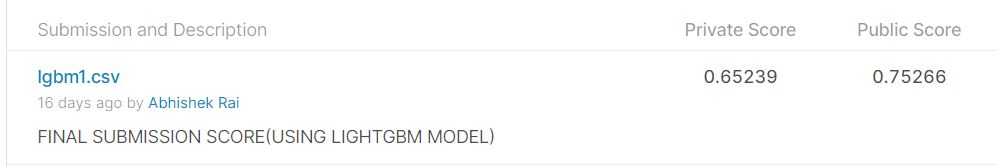

In [ ]:
from IPython.display import Image
Image(filename='/content/FINAL_SUBMISS.JPG') 